In [223]:
import numpy as np
from tqdm import tqdm
import scipy.integrate
import numba
import matplotlib.pyplot as plt
import sim

In [224]:
M = 1
r = 1
vol = (4/3) * np.pi * r**3
p = M/vol

def rho(r):
    if r <= 1:
        return p
    return 0

def rhoNFW(r,c,Mvir = 1):
    Rs = 1/c
    p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
    return p0/((r/Rs)*((1+(r/Rs))**2))

def radius(alpha,beta,d,particle):
    sphere = d * np.array([np.cos(alpha)*np.sin(beta),np.sin(alpha)*np.sin(beta),np.cos(beta)])
    return np.linalg.norm(sphere + particle)

def rho_sphere(alpha,beta,d,particle):
    sphere = d * np.array([np.cos(alpha)*np.sin(beta),np.sin(alpha)*np.sin(beta),np.cos(beta)])
    r = np.linalg.norm(sphere + particle)
    if r <= 1:
        return 1/((4/3) * np.pi)
    else:
        return 0

def rho_sphere_NFW(alpha,beta,d,particle,c=5):
    r = radius(alpha,beta,d,particle)
    if r > 3:
        return 0
    return rhoNFW(r,c)


In [225]:
@numba.jit()
def thing(particle,masses,phis,nds=100,nangles=100,c=7,Mvir=1,G=1):
    print(np.sqrt(np.sum(particle**2)))
    ds = np.linspace(0,np.sqrt(np.sum(particle**2))+3,nds+1)[1:]

    alphas = np.linspace(0,2*np.pi,nangles)
    betas = np.linspace(0,2*np.pi,nangles)

    dd = ds[1]-ds[0]

    dalpha = alphas[1] - alphas[0]
    dbeta = betas[1] - betas[0]
    idx = 0
    for d in ds:
        dr = 4 * np.pi * (d**2) * dd/(nangles**2)
        out = 0
        for alpha in alphas:
            for beta in betas:
                
                sphere = d * np.array([np.cos(alpha)*np.sin(beta),np.sin(alpha)*np.sin(beta),np.cos(beta)])
                r = np.sqrt(np.sum((sphere + particle)**2)) + 0.0001
                if r > 3:
                    density = 0
                elif r == 0:
                    density = 0
                else:
                    Rs = 1/c
                    p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
                    density = p0/((r/Rs)*((1+r/Rs)**2))

                out += density * dr
        masses[idx] = out
        phis[idx] = -G * out / d
        idx += 1
    return ds

1.0
-0.050210279981430635
-0.0008945077589772075


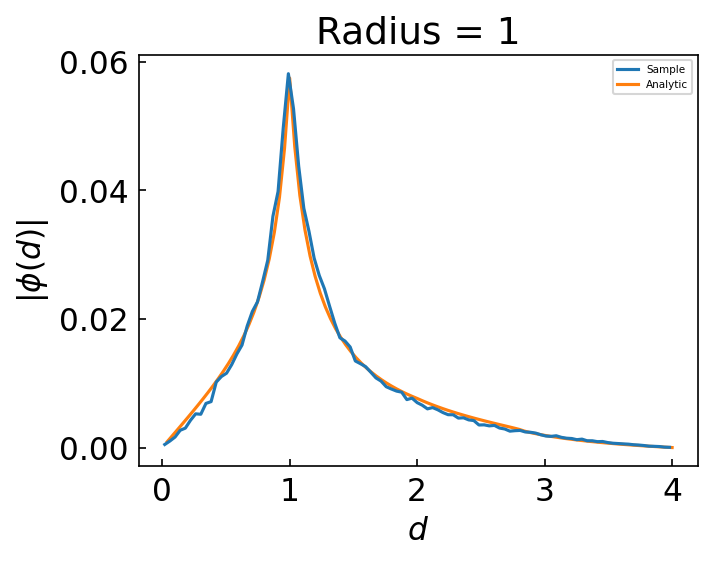

In [188]:
ri = 1
c = 5
a = 3
G = 1
n = 100000
sampled = sim.halos.Sample.NFW(n,c=c,a=a)
particles = sampled.loc[:,["x","y","z"]].to_numpy()

dists = np.linalg.norm(particles - np.array([ri,0,0]),axis=1)
M = sampled["mass"][0]
phis = -G * M / dists

nbins = 100

bins = np.linspace(0,a + ri,nbins)
start = bins[:-1]
end = bins[1:]
step = bins[1]-bins[0]
xs = (end-start)/2 + start
ys = []
for idx in range(len(start)):
    temp_dists = dists[dists > start[idx]]
    temp_phis = phis[dists > start[idx]]
    temp_phis = temp_phis[temp_dists <= end[idx]]
    ys.append(np.sum(temp_phis))

masses = np.zeros(100,dtype=float)
ana_phis = np.zeros(100,dtype=float)
ana_xs = thing(np.array([ri,0,0]),masses,ana_phis,nds=100,nangles=100,c=c)

sim.pretty_plots.plot_pretty()

plt.plot(xs,ys/np.sum(ys),label="Sample",zorder=1)
plt.plot(ana_xs,ana_phis/np.sum(ana_phis),label="Analytic",zorder=0)
print(scipy.integrate.trapz(ana_phis,ana_xs))
print(np.sum(ys))
plt.title("Radius = " + str(ri))

plt.xlabel(r"$d$")
plt.ylabel(r"$|\phi(d)|$")

plt.legend()
plt.tight_layout()
plt.savefig("NFW_phicontributions_r" + str(ri).replace(".",",") + "n=" + str(n) + ".jpg")
plt.show()